In [28]:
# %pip uninstall protobuf -y


In [29]:
# %pip install tensor

In [30]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import random

In [31]:
# # Parameters
# N_AGENTS = 100
# BAR_CAPACITY = 60
# WEEKS = 100
# SEQUENCE_LENGTH = 50

# # Generate dummy attendance history
# def generate_initial_attendance(weeks=SEQUENCE_LENGTH):
#     return [random.randint(40, 70) for _ in range(weeks)]

# # Build LSTM predictor
# def build_lstm_model():
#     model = Sequential([
#         LSTM(10, input_shape=(SEQUENCE_LENGTH, 1), return_sequences=False),
#         Dense(1)
#     ])
#     model.compile(optimizer='adam', loss='mse')
#     return model

# # Simple Q-learning Agent
# class Agent:
#     def __init__(self):
#         self.q_table = np.zeros((2,))  # 0: stay home, 1: go
#         self.alpha = 0.1
#         self.gamma = 0.95
#         self.epsilon = 0.2
#         self.lstm = build_lstm_model()
#         self.past_attendance = generate_initial_attendance()
#         # Train the LSTM model with the dummy data
#         X = np.array([self.past_attendance[i:i+SEQUENCE_LENGTH] for i in range(len(self.past_attendance) - SEQUENCE_LENGTH)])
#         y = np.array(self.past_attendance[SEQUENCE_LENGTH:])
#         if len(X) > 0:
#             self.lstm.fit(X.reshape(-1, SEQUENCE_LENGTH, 1), y, epochs=20, verbose=0)

#     def predict_attendance(self):
#         sequence = np.array(self.past_attendance[-SEQUENCE_LENGTH:]).reshape(1, SEQUENCE_LENGTH, 1)
#         prediction = self.lstm.predict(sequence, verbose=0)[0][0]
#         return prediction

#     def decide(self, predicted_attendance):
#         if random.random() < self.epsilon:
#             return random.choice([0, 1])
#         else:
#             return np.argmax(self.q_table)

#     def update_q(self, action, reward):
#         self.q_table[action] = self.q_table[action] + self.alpha * (reward + self.gamma * np.max(self.q_table) - self.q_table[action])

#     def update_attendance_history(self, value):
#         self.past_attendance.append(value)
#         if len(self.past_attendance) > SEQUENCE_LENGTH + 1:
#             self.past_attendance.pop(0)

# # Initialize agents
# agents = [Agent() for _ in range(N_AGENTS)]

# # Simulation
# history = generate_initial_attendance(weeks=SEQUENCE_LENGTH)
# for week in range(WEEKS):
#     decisions = []
#     predictions = []
#     for agent in agents:
#         pred = agent.predict_attendance()
#         predictions.append(pred)
#         action = agent.decide(pred)
#         decisions.append(action)
    
#     attendance = sum(decisions)
#     history.append(attendance)
#     history = history[-(SEQUENCE_LENGTH + 1):]

#     for i, agent in enumerate(agents):
#         reward = 1 if (decisions[i] == 1 and attendance <= BAR_CAPACITY) else -1 if decisions[i] == 1 else 0.5
#         agent.update_q(decisions[i], reward)
#         agent.update_attendance_history(attendance)


In [32]:
# # Parameters
# N_AGENTS = 100
# BAR_CAPACITY = 60
# WEEKS = 1000
# SEQUENCE_LENGTH = 500

# # Generate dummy attendance history with high initial attendance
# def generate_initial_attendance(weeks=SEQUENCE_LENGTH):
#     # Start with high attendance (close to or above bar capacity)
#     return [random.randint(50, 80) for _ in range(weeks)]

# # Build LSTM predictor
# def build_lstm_model():
#     model = Sequential([
#         LSTM(10, input_shape=(SEQUENCE_LENGTH, 1), return_sequences=False),
#         Dense(1)
#     ])
#     model.compile(optimizer='adam', loss='mse')
#     return model

# # Simple Q-learning Agent
# class Agent:
#     def __init__(self):
#         self.q_table = np.zeros((2,))  # 0: stay home, 1: go
#         self.alpha = 0.1
#         self.gamma = 0.95
#         self.epsilon = 0.5  # Start with higher exploration rate
#         self.lstm = build_lstm_model()
#         self.past_attendance = generate_initial_attendance()
#         # Train the LSTM model with the dummy data
#         X = np.array([self.past_attendance[i:i+SEQUENCE_LENGTH] for i in range(len(self.past_attendance) - SEQUENCE_LENGTH)])
#         y = np.array(self.past_attendance[SEQUENCE_LENGTH:])
#         if len(X) > 0:
#             self.lstm.fit(X.reshape(-1, SEQUENCE_LENGTH, 1), y, epochs=20, verbose=0)

#     def predict_attendance(self):
#         sequence = np.array(self.past_attendance[-SEQUENCE_LENGTH:]).reshape(1, SEQUENCE_LENGTH, 1)
#         prediction = self.lstm.predict(sequence, verbose=0)[0][0]
#         return prediction

#     def decide(self, predicted_attendance):
#         if random.random() < self.epsilon:
#             return random.choice([0, 1])
#         else:
#             return np.argmax(self.q_table)

#     def update_q(self, action, reward):
#         self.q_table[action] = self.q_table[action] + self.alpha * (reward + self.gamma * np.max(self.q_table) - self.q_table[action])

#     def update_attendance_history(self, value):
#         self.past_attendance.append(value)
#         if len(self.past_attendance) > SEQUENCE_LENGTH + 1:
#             self.past_attendance.pop(0)

# # Initialize agents
# agents = [Agent() for _ in range(N_AGENTS)]

# # # Simulation
# # history = generate_initial_attendance(weeks=SEQUENCE_LENGTH)
# # for week in range(WEEKS):
# #     decisions = []
# #     predictions = []
# #     for agent in agents:
# #         pred = agent.predict_attendance()
# #         predictions.append(pred)
# #         action = agent.decide(pred)
# #         decisions.append(action)
    
# #     attendance = sum(decisions)
# #     history.append(attendance)
# #     history = history[-(SEQUENCE_LENGTH + 1):]

# #     for i, agent in enumerate(agents):
# #         reward = 2 if (decisions[i] == 1 and attendance <= BAR_CAPACITY) else -1 if decisions[i] == 1 else 0.5
# #         agent.update_q(decisions[i], reward)
# #         agent.update_attendance_history(attendance)
    
# #     # Gradually reduce exploration rate (epsilon) over time
# #     for agent in agents:
# #         agent.epsilon = max(0.1, agent.epsilon * 0.99)  # Minimum epsilon of 0.1

In [33]:
# from tqdm import tqdm  # Import tqdm for progress bar

# # Simulation with tqdm progress bar
# history = generate_initial_attendance(weeks=SEQUENCE_LENGTH)
# for week in tqdm(range(WEEKS), desc="Simulating Weeks"):
#     decisions = []
#     predictions = []
#     for agent in agents:
#         pred = agent.predict_attendance()
#         predictions.append(pred)
#         action = agent.decide(pred)
#         decisions.append(action)
    
#     attendance = sum(decisions)
#     history.append(attendance)
#     history = history[-(SEQUENCE_LENGTH + 1):]

#     for i, agent in enumerate(agents):
#         reward = 2 if (decisions[i] == 1 and attendance <= BAR_CAPACITY) else -1 if decisions[i] == 1 else 0.5
#         agent.update_q(decisions[i], reward)
#         agent.update_attendance_history(attendance)
    
#     # Gradually reduce exploration rate (epsilon) over time
#     for agent in agents:
#         agent.epsilon = max(0.1, agent.epsilon * 0.99)  # Minimum epsilon of 0.1

In [ ]:
# Improved El Farol Bar Simulation with Dynamic Behavior and Better Rewards
import random
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tqdm import tqdm

# Parameters
N_AGENTS = 100
BAR_CAPACITY = 60
TOO_FEW = 20
WEEKS = 100
SEQUENCE_LENGTH = 300 # Keep 1:3 ratio for weeks to sequence length

# Generate dummy attendance history with high initial attendance
def generate_initial_attendance(weeks=SEQUENCE_LENGTH):
    return [random.randint(50, 80) for _ in range(weeks)]

# Build LSTM predictor
def build_lstm_model():
    model = Sequential([
        LSTM(32, input_shape=(SEQUENCE_LENGTH, 1), return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Q-learning Agent with LSTM and personality traits
class Agent:
    def __init__(self):
        self.q_table = np.zeros((2,))  # 0: stay home, 1: go
        self.alpha = 0.1
        self.gamma = 0.95
        self.epsilon = 0.5  # Initial exploration rate
        self.lstm = build_lstm_model()
        self.past_attendance = generate_initial_attendance()
        X = np.array([self.past_attendance[i:i+SEQUENCE_LENGTH] for i in range(len(self.past_attendance) - SEQUENCE_LENGTH)])
        y = np.array(self.past_attendance[SEQUENCE_LENGTH:])
        if len(X) > 0:
            self.lstm.fit(X.reshape(-1, SEQUENCE_LENGTH, 1), y, epochs=20, verbose=0)

    def predict_attendance(self):
        sequence = np.array(self.past_attendance[-SEQUENCE_LENGTH:]).reshape(1, SEQUENCE_LENGTH, 1)
        prediction = self.lstm.predict(sequence, verbose=0)[0][0]
        return prediction

    def decide(self, predicted_attendance):
        if random.random() < self.epsilon:
            return random.choice([0, 1])
        else:
            return np.argmax(self.q_table)

    def update_q(self, action, reward):
        self.q_table[action] += self.alpha * (reward + self.gamma * np.max(self.q_table) - self.q_table[action])

    def update_attendance_history(self, value):
        self.past_attendance.append(value)
        if len(self.past_attendance) > SEQUENCE_LENGTH + 1:
            self.past_attendance.pop(0)

# Initialize agents
agents = [Agent() for _ in range(N_AGENTS)]

# Simulation
history = generate_initial_attendance(weeks=SEQUENCE_LENGTH)
for week in tqdm(range(WEEKS), desc="Simulating Weeks"):
    decisions = []
    predictions = []

    for agent in agents:
        pred = agent.predict_attendance()
        predictions.append(pred)
        action = agent.decide(pred)
        decisions.append(action)

    attendance = sum(decisions)

    # Dynamic early leaving if overcrowded
    if attendance > BAR_CAPACITY:
        leavers = int(0.3 * attendance)  # 30% leave early due to discomfort
        attendance -= leavers

    history.append(attendance)
    history = history[-(SEQUENCE_LENGTH + 1):]

    for i, agent in enumerate(agents):
        if decisions[i] == 1:
            if TOO_FEW < attendance <= BAR_CAPACITY:
                reward = 2  # Party is just right
            else:
                reward = -2  # Too crowded or too empty
        else:
            reward = -0.8  # Slight punishment for staying home

        agent.update_q(decisions[i], reward)
        agent.update_attendance_history(attendance)

    # Gradually reduce exploration rate (epsilon)
    for agent in agents:
        agent.epsilon = max(0.1, agent.epsilon * 0.99)


Simulating Weeks: 100%|██████████| 100/100 [13:40<00:00,  8.20s/it]


In [35]:
print("BAR_CAPACITY:", BAR_CAPACITY)
print("N_AGENTS:", N_AGENTS)
print("SEQUENCE_LENGTH:", SEQUENCE_LENGTH)
print("WEEKS:", WEEKS)
print("Current Week:", week)
print("Attendance:", attendance)
print("Decisions:", decisions)
print("Predictions:", predictions)
print("History:", history)
print("Reward:", reward)

BAR_CAPACITY: 60
N_AGENTS: 100
SEQUENCE_LENGTH: 300
WEEKS: 100
Current Week: 99
Attendance: 63
Decisions: [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1]
Predictions: [-0.5091007, 0.39938396, 0.6359, -0.063175894, -0.042291038, 0.68905634, -0.20390043, 0.23626952, -0.22779608, 0.078988336, 0.5205384, 0.4800103, 0.19148336, -0.23106517, -0.19143051, -0.90491474, 1.0854002, 0.12462441, -0.24520953, -0.94897693, 1.2428411, -1.1019979, 0.32476893, 0.10718318, 0.9092975, 0.4951476, 0.25862265, 0.396314, 0.4489798, 1.3907216, -0.428826, -0.062245235, -0.6815067, 0.850186, -0.40779233, 0.5935561, 1.7120833, -0.71476203, 0.5857478, -0.6253195, 0.33429205, -0.19269244, 0.051145, 0.16516824, 0.0036836492, 0.20365846, -1.1117146, 0.016783476, 0.246

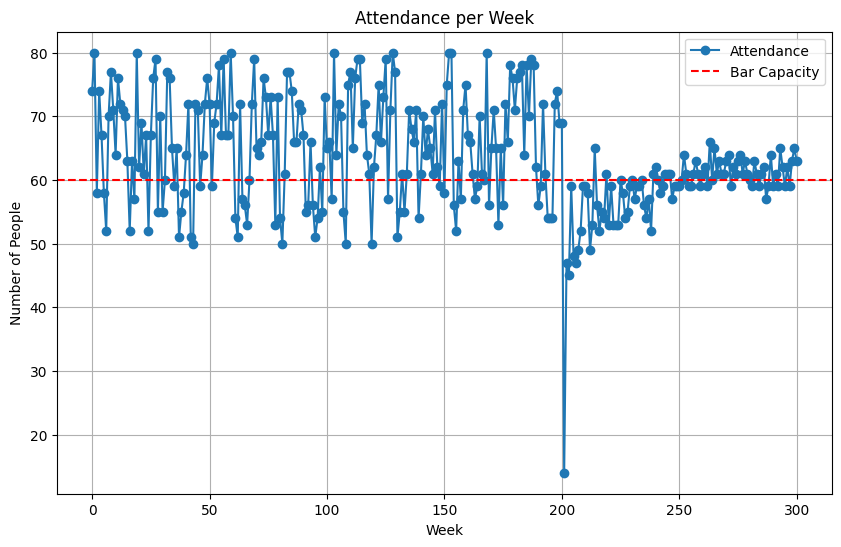

In [36]:
import matplotlib.pyplot as plt

# Plot attendance history
plt.figure(figsize=(10, 6))
plt.plot(range(len(history)), history, marker='o', label='Attendance')
plt.axhline(y=BAR_CAPACITY, color='r', linestyle='--', label='Bar Capacity')
plt.title('Attendance per Week')
plt.xlabel('Week')
plt.ylabel('Number of People')
plt.legend()
plt.grid()
plt.show()

In [37]:
from collections import Counter

# Count the frequency of attendance values
attendance_frequency = Counter(history)

# Display the frequency
print("Attendance Frequency per Week:")
for attendance_value, frequency in sorted(attendance_frequency.items()):
    print(f"Attendance: {attendance_value}, Frequency: {frequency}")

Attendance Frequency per Week:
Attendance: 14, Frequency: 1
Attendance: 45, Frequency: 1
Attendance: 47, Frequency: 2
Attendance: 48, Frequency: 1
Attendance: 49, Frequency: 2
Attendance: 50, Frequency: 4
Attendance: 51, Frequency: 5
Attendance: 52, Frequency: 7
Attendance: 53, Frequency: 8
Attendance: 54, Frequency: 10
Attendance: 55, Frequency: 10
Attendance: 56, Frequency: 9
Attendance: 57, Frequency: 10
Attendance: 58, Frequency: 7
Attendance: 59, Frequency: 29
Attendance: 60, Frequency: 10
Attendance: 61, Frequency: 28
Attendance: 62, Frequency: 11
Attendance: 63, Frequency: 11
Attendance: 64, Frequency: 12
Attendance: 65, Frequency: 13
Attendance: 66, Frequency: 10
Attendance: 67, Frequency: 11
Attendance: 68, Frequency: 2
Attendance: 69, Frequency: 5
Attendance: 70, Frequency: 8
Attendance: 71, Frequency: 11
Attendance: 72, Frequency: 15
Attendance: 73, Frequency: 5
Attendance: 74, Frequency: 4
Attendance: 75, Frequency: 4
Attendance: 76, Frequency: 8
Attendance: 77, Frequency: 

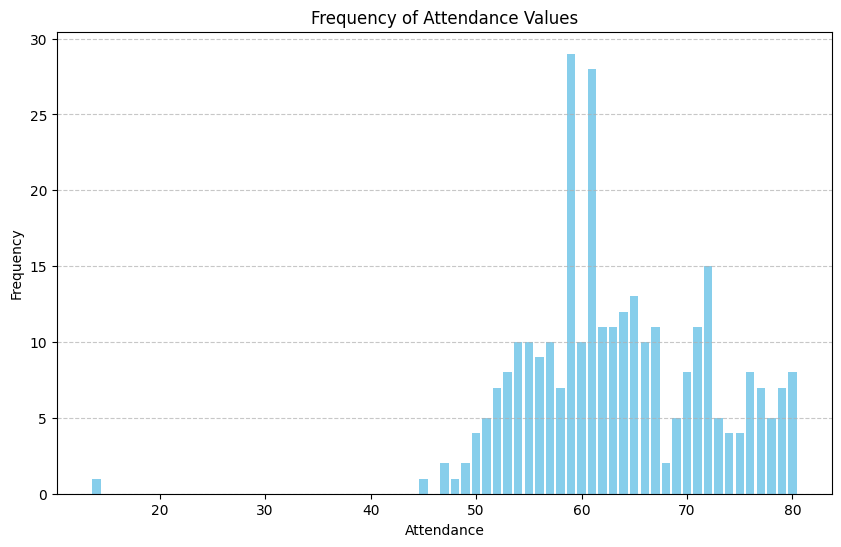

In [38]:
# Visualize the frequency of attendance values
plt.figure(figsize=(10, 6))
plt.bar(attendance_frequency.keys(), attendance_frequency.values(), color='skyblue')
plt.title('Frequency of Attendance Values')
plt.xlabel('Attendance')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


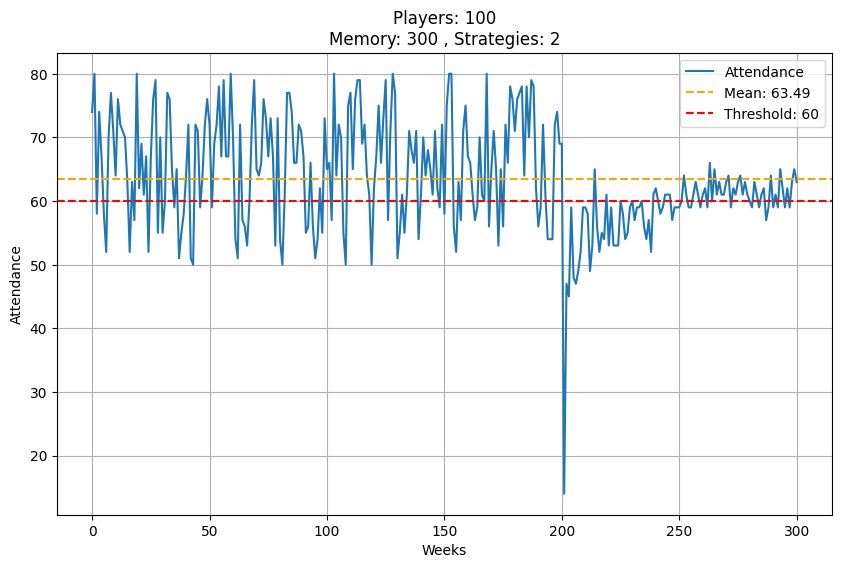

In [39]:
# Calculate the mean attendance
mean_data = np.mean(history)

# Plot the attendance history and mean
plt.figure(figsize=(10, 6))
plt.plot(history, label='Attendance')
plt.axhline(y=mean_data, color='orange', linestyle='--', label='Mean: ' + str(round(mean_data, 2)))
plt.axhline(y=BAR_CAPACITY, color='red', linestyle='--', label='Threshold: 60')
plt.legend()
plt.xlabel("Weeks")
plt.ylabel("Attendance")
plt.grid()
plt.title("Players: " + str(N_AGENTS) + "\nMemory: " + str(SEQUENCE_LENGTH) + " , Strategies: 2")
plt.show()

In [43]:
import pandas as pd

# Create a DataFrame from the simulation data
# Truncate the history to match the length of predictions and decisions
min_length = min(len(history), len(predictions), len(decisions))

data = {
    "Week": list(range(min_length)),
    "Attendance": history[:min_length],
    "Decisions": decisions[:min_length],
    "Predictions": predictions[:min_length],
    "Reward": [reward] * min_length  # Example: Same reward for all weeks
}

df = pd.DataFrame(data)

# Display the DataFrame
print(df.head())

# Save the DataFrame to a CSV file
df.to_csv("reinforcement_learning_data.csv", index=False)

print("Data saved to 'reinforcement_learning_data.csv'")

   Week  Attendance  Decisions  Predictions  Reward
0     0          74          1    -0.509101      -2
1     1          80          1     0.399384      -2
2     2          58          1     0.635900      -2
3     3          74          1    -0.063176      -2
4     4          67          1    -0.042291      -2
Data saved to 'reinforcement_learning_data.csv'
